# Project 06. Pricing Test

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Read Data](#readdata)
  2. [Check Randomness](#checkrandomness)
  3. [Question 1](#question1)
  4. [Question 2](#question2)
  

<a id='read_data'></a>
## Read Data

In [56]:
# read test table and check information
test = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/6. Pricing_Test/test_results.csv')
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [58]:
column = ['source','device','operative_system']
[test[x].nunique() for x in column]

[12, 2, 6]

In [59]:
# read user table and check information
user = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/6. Pricing_Test/user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [60]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [61]:
[user[x].nunique() for x in ['country','city']]

[1, 923]

Since in user table the 'country' column only has one country (USA) and a wide city distribution, there are not useful information to the problems, so just ignore this table temporarily.

In [62]:
# check if there are any problem with the data
test.groupby(['test','price'])['user_id'].count()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: user_id, dtype: int64

It can be seen that there are actually some problems with the data since in control there are some users who see price 59 and in test some users can see the price 39. So, before answer the question, we should remove them first.

In [63]:
# remove the unvalid data
test = test[((test['test'] ==0) & (test['price'] == 39)) | ((test['test'] == 1) & (test['price'] == 59))]

<a id='checkrandomness'></a>
## Check randomness
check whether test and control groups is randomly splitted?

In [64]:
# Transfer the categorical columns to be numbers
test1 = test.copy()
test1['source']=LabelEncoder().fit_transform(test1['source'])
test1['device']=LabelEncoder().fit_transform(test1['device'])
test1['operative_system']=LabelEncoder().fit_transform(test1['operative_system'])
test1.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,3,0,1,0,39,0
1,624057,2015-05-10 21:08:46,8,0,0,0,39,0
2,317970,2015-04-04 15:01:23,0,0,0,0,39,0
3,685636,2015-05-07 07:26:01,5,0,1,1,59,0
4,820854,2015-05-24 11:04:40,3,1,3,0,39,0


In [65]:
columns = ['source','device','operative_system']
ch2values,pvalues = chi2(test1[columns],test1["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = columns).sort_values(by='pvalue')

,chi2_value,pvalue
operative_system,83.937937,5.105534e-20
device,44.785346,2.198620e-11
source,0.918060,3.379849e-01


From above result, it can be known that "both operative_system" and "device" has some relationship with test, which means the test are not random and operative system and device has some impact on the split

In [66]:
# to check which one in operative system are abnormal
def dis_ratios(df):
    d = df.value_counts(normalize = True)
    return d
os_test = test.groupby('operative_system')['test'].apply(dis_ratios).unstack()
os_test

,0,1
operative_system,,
android,0.643475,0.356525
iOS,0.648045,0.351955
linux,0.533656,0.466344
mac,0.652365,0.347635
other,0.647895,0.352105
windows,0.629817,0.370183


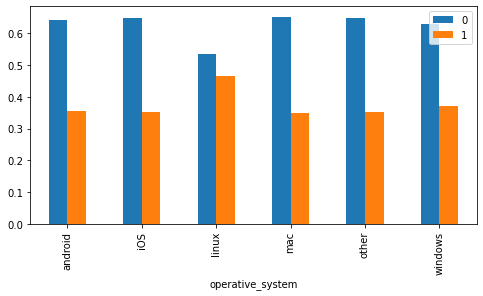

In [67]:
# visualize the relationship beteen detailed operative system and their ratios in test/control
os_test.plot(kind = 'bar',figsize=(8,4))

It is very clearly that "Linux" is abnormal since the experimental claim that 66% of the users saw the 39, while a random sample of 33% users use the 59, but clients using linux don't obey this rule. So, the linux users in operative system are not randomly choosen. 

In [68]:
# to check how the device infulence the test/control experiment
de_test = test.groupby('device')['test'].apply(dis_ratios).unstack()
de_test

,0,1
device,,
mobile,0.646218,0.353782
web,0.631092,0.368908


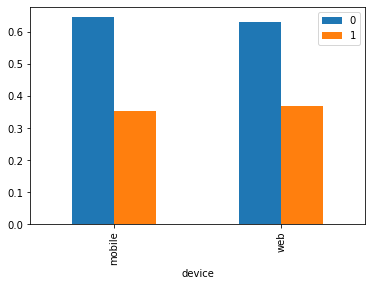

In [69]:
# visulaize the rationship between different device and their ratios in test/control
de_test.plot(kind = 'bar')

It can been seen from the above device barplot that the ratio between test and control in diferent devices are a little different, but not much, which can be ignored. The reason why this has been listed in chi2 test maybe because chi2 test is sensitive to sample size and when sample size is very large, small difference will appear statistically significant.

<a id='question1'></a>
## Question 1
Should the company sell its software for 39 or 59?

In [70]:
# check the convert rate and average revenue for 39 and 59
test['per_revenue'] = test['price'] * test['converted']

summary = pd.DataFrame({'convert_rate': test.groupby('test')['converted'].mean(),
                         'total_revenue': test.groupby('test')['per_revenue'].sum(),
                         'average_revenue': test.groupby('test')['per_revenue'].mean()})
summary

,convert_rate,total_revenue,average_revenue
test,,,
0,0.019900,157170,0.776083
1,0.015555,104548,0.917748


Perform a t-test to test whether the test groups'average revenue is higher than control's or not:

H0: test group's average revenue = control groups'average revenue;
    
HA: test group's average revenue > control groups'average revenue

In [71]:
# calculate the p_value of t-test
a = test[test['test']==0]['per_revenue']
b = test[test['test']==1]['per_revenue']
t_test_result = ss.ttest_ind(a, b,equal_var = False)
p_value = t_test_result.pvalue/2
p_value

5.486288656210391e-09

Answer to Q1:
Since the p-value is much smaller than 0.05, so we can reject H0 and accept HA, which means the test groups'average revenue is significantly higher than the control groups'.

However, as show before, the operative system distribution in the test and control groups are not the same, so price isn't the only difference between these two groups, we can't controbite the higher average revenue to price.

Based on the current experiment, I can't answer which price the company should choose, and I would suggest first to modify the experiment and make it randomness, then rerun the experiment.

<a id='question2'></a>
## Question 2
The VP of Product is interested in having a holistic view into user behaviro, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [72]:
# run chi2 test to see which feature greatly impact "converted"
columns = ['source','device','operative_system','price']
ch2values,pvalues = chi2(test1[columns],test1["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = columns).sort_values(by='pvalue')

,chi2_value,pvalue
price,152.509801,4.902372e-35
operative_system,7.378510,6.600782e-03
source,2.451427,1.174181e-01
device,0.706940,4.004615e-01


It can be found from above result, 'price' and 'operative_system' are two main factor which impact converted more. And "source" and 'device' didn't show impact on conversion rate.

In [73]:
# check how price affects converted
price_converted = test.groupby('price')['converted'].apply(lambda a: a.value_counts(normalize = True)).unstack()
price_converted

,0,1
price,,
39,0.980100,0.019900
59,0.984445,0.015555


In [74]:
# chek how operative_system affects convertion rate
os_converted = test.groupby('operative_system')['converted'].apply(lambda a: a.value_counts(normalize =True)).unstack().sort_values(by=1)
os_converted

,0,1
operative_system,,
linux,0.991768,0.008232
other,0.987019,0.012981
android,0.985081,0.014919
windows,0.983034,0.016966
iOS,0.977672,0.022328
mac,0.976013,0.023987


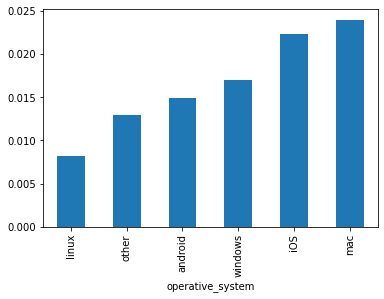

In [75]:
# visualize the conversion_rate of different operative system
os_converted[1].plot(kind='bar')

In [105]:
# Model by Decision Tree
#I will build a Decision Tree to get important features.Since I want to get the detailed operative system or device, source effect on the conversion rate, I will use One-Hot-Encoding to transfer categorical features to numbers
test2 = test.copy()
test2 = test2.drop(columns=['timestamp','test','per_revenue','user_id'])
test2 = pd.get_dummies(test2)
test2 = test2.drop(columns=['operative_system_other','device_web','source_ads_other'])

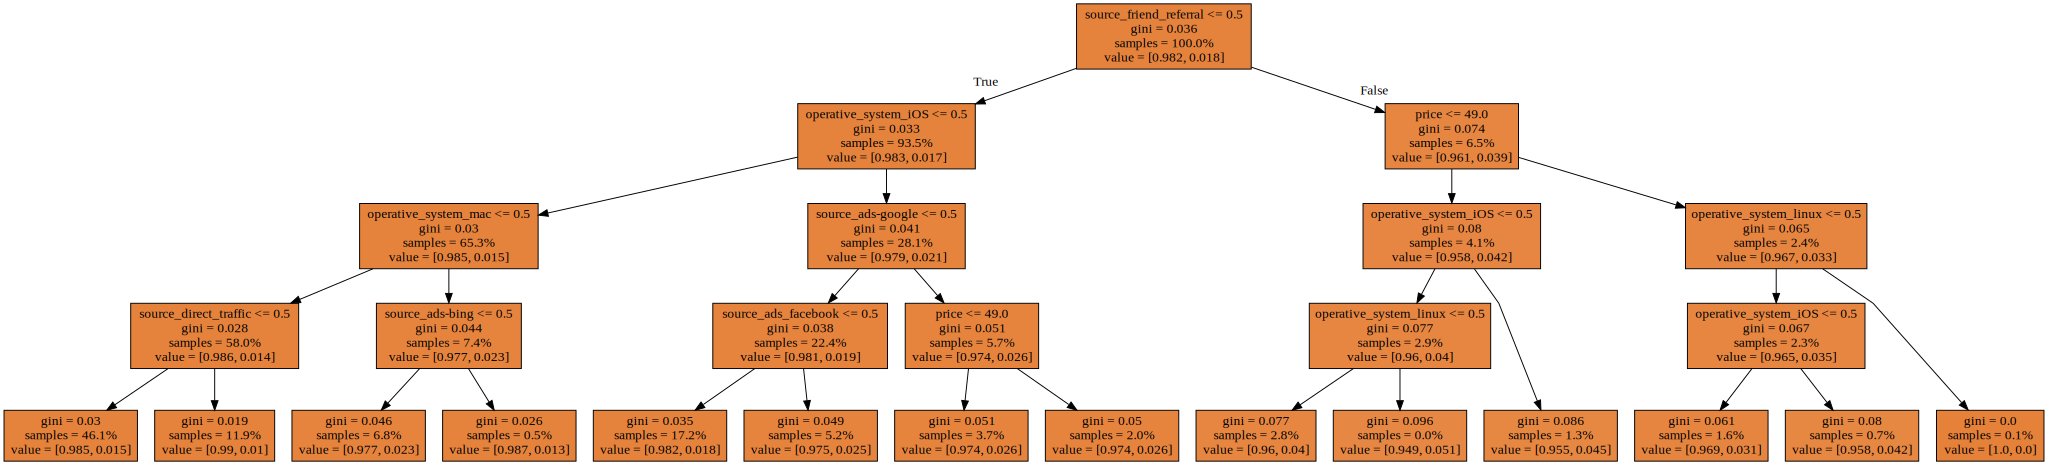

In [111]:
xtrain = test2.drop(columns='converted')
ytrain = test2['converted']

dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(xtrain,ytrain)
dot_data = tree.export_graphviz(dt,feature_names=xtrain.columns,proportion=True, filled = True,leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph

It can be seen from Decision Tree, to reach the leaf node with highest converstion rate, the path is 1)source_friend_referral = True, 2)price<49, 3)operative_system_ios=True.

In [109]:
# check feature imporatance using sklean in built function
pd.Series(dt.feature_importances_,index = xtrain.columns).sort_values(ascending = False)

source_friend_referral      0.581165
operative_system_iOS        0.136965
operative_system_mac        0.093429
source_direct_traffic       0.059473
source_ads_facebook         0.041326
source_ads-google           0.038754
price                       0.020501
operative_system_linux      0.017944
source_ads-bing             0.010442
source_ads-yahoo            0.000000
operative_system_windows    0.000000
source_seo-bing             0.000000
source_seo-other            0.000000
source_seo-yahoo            0.000000
source_seo_facebook         0.000000
device_mobile               0.000000
operative_system_android    0.000000
source_seo-google           0.000000
dtype: float64

Answer to Q2:
1.  'price' and 'operative_system' are two main genearal factors which impact converted more. And higher price showed lower conversion rate compared with that of lower price. This makes sense since there are relatively fewer people to buy products with higher price.


2. Mac and iOS has higher conversion rate compared with those using other operative system. Since all the users are in Amercia and people in American perfer to products from Apple, so we can increase the ad appeared on mac and iphone and launch special marketing progream targeted to Apple users.


3. Linux User showed the lowest conversion rate. Development team should find out the reason. For example, if is there any incompatibility issue on Linux? Is the propaganda that software works well in Linux not enough? 


4. Friend_referral,apple user(Mac and iOS), low price are main detailed positive factors that improve the conversion rate. If you want to increase the price, we must compensate on the other two factors. For example, rewards user who invite his/her friend to use the software.